# EDA

In [115]:
import boto3
import geopandas as gpd
import io
import json
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns; #sns.set(style="ticks", color_codes=True)
from shapely.geometry import Point

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [64]:
# AWS credentials to read files on S3 bucket
f = open('../credentials.json')
credentials = json.load(f)

s3_client = boto3.client(
    "s3",
    aws_access_key_id=credentials["Access key ID"],
    aws_secret_access_key=credentials["Secret access key"]
)

s3_resource = boto3.resource(
    "s3",
    aws_access_key_id=credentials["Access key ID"],
    aws_secret_access_key=credentials["Secret access key"]
)

In [65]:
def remove_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1

    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    df_filtrado = df[(df[feature] > limite_inferior) & (df[feature] < limite_superior)]
    return df_filtrado

In [66]:
# # getting preprocessed data
# stations = []
# ts_min = []
# ts_max = []

# df_full = []
# prefix_objs = s3_resource.Bucket("cge").objects.filter(Prefix="processed")
# keys = [obj.key for obj in prefix_objs]
# for key in keys[1:]:
#     obj = s3_client.get_object(Bucket="cge", Key=key)
#     df = pd.read_csv(io.BytesIO(obj["Body"].read()))
#     df['timestamp'] = pd.to_datetime(df['timestamp'])
#     df["date"] = df.timestamp.dt.date
#     df = remove_outliers(df=df, feature='temperature_lag_1H')
        
#     try:
#         colunas_media = [
#             "precipitation_lag_1H",
#             "temperature_lag_1H",
#             "relative_humidity_lag_1H",
#             "pressure_lag_1H",
#             "wind_velocity_x_lag_1H",
#             "wind_velocity_y_lag_1H",
#             "wind_blow_x_lag_1H",
#             "wind_blow_y_lag_1H"
#         ]
        
#         df_grouped = df[["station_name", "date", "temperature_lag_1H"]].groupby(["station_name", "date"]).max()
#         df_grouped = df_grouped.rename(columns={"temperature_lag_1H": "temperature_max_lag_1H"})
#         for coluna in colunas_media:
#             df_grouped[coluna] = df.groupby(["station_name", "date"])[coluna].mean()
        
#         df_grouped = df_grouped.reset_index()
#         df_grouped = df_grouped.drop(columns=['date'])
#         df_grouped = df_grouped.groupby("station_name", as_index=False).mean()
#     except:
#         colunas_media = [
#             "precipitation_lag_1H",
#             "temperature_lag_1H",
#             "relative_humidity_lag_1H",
#             "pressure_lag_1H"
#         ]

#         df_grouped = df[["station_name", "date", "temperature_lag_1H"]].groupby(["station_name", "date"]).max()
#         df_grouped = df_grouped.rename(columns={"temperature_lag_1H": "temperature_max_lag_1H"})
#         for coluna in colunas_media:
#             df_grouped[coluna] = df.groupby(["station_name", "date"])[coluna].mean()
        
#         df_grouped = df_grouped.reset_index()
#         df_grouped = df_grouped.drop(columns=['date'])
#         df_grouped = df_grouped.groupby("station_name", as_index=False).mean()

#     stations.append(df.station_name.unique()[0])
#     df['timestamp'] = pd.to_datetime(df['timestamp'])
#     ts_min.append(df['timestamp'].min())
#     ts_max.append(df['timestamp'].max())

#     df_full.append(df_grouped)

# df_grouped = pd.concat(df_full)
# df_grouped.to_csv('df_grouped.csv', index=False)
# df_grouped

In [67]:
df_grouped = pd.read_csv('df_grouped.csv')
df_grouped = df_grouped[df_grouped["station_name"].str.contains("Parelheiros") == False]
df_grouped.columns = [i.split("_lag_1H")[0] for i in list(df_grouped.columns)]
df_grouped = df_grouped.rename(columns={"station_name": "station"})
df_grouped = df_grouped.drop(columns=["temperature_max", "pressure", "wind_velocity_x", "wind_velocity_y", "wind_blow_x", "wind_blow_y"])

df_grouped

,station,precipitation,temperature,relative_humidity
0,Anhembi,1.860340,20.799166,75.495413
1,Butantã,2.031074,20.445426,80.674328
2,Campo Limpo,1.704243,20.769885,78.881693
3,Capela do Socorro,1.739865,18.893560,89.509712
4,Cidade Ademar,1.771956,20.601012,76.677048
5,Freguesia do Ó,2.104188,20.627032,79.192017
6,Ipiranga,1.879577,20.173128,81.060309
7,Itaim Paulista,1.808285,20.263566,81.015760
8,Itaquera,1.845294,19.936505,81.154465
9,Jabaquara,2.063883,19.194426,73.223958


In [68]:
stations = pd.read_csv("estacoes_meteorologicas_cge.csv")
stations[['station', 'lat', 'lon']].to_latex('stations_table.tex', index=False)

stations

/tmp/ipykernel_1660/1745926131.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  stations[['station', 'lat', 'lon']].to_latex('stations_table.tex', index=False)


,station,lat,lon
0,Sé,-23.552718,-46.656168
1,Anhembi,-23.518626,-46.643757
2,Vila Mariana,-23.584720,-46.635560
3,Ipiranga,-23.632978,-46.583518
4,Campo Limpo,-23.658180,-46.767490
5,M'Boi Mirim,-23.671266,-46.727361
6,Santo Amaro,-23.634789,-46.667657
7,Jabaquara,-23.650814,-46.646581
8,Cidade Ademar,-23.667670,-46.674160
9,Capela do Socorro,-23.781133,-46.725217


In [69]:
def get_uhct_radius_percentage(uhct_feature):
    df_uhct = []
    for i in range(0, len(stations)):
        # Carregar o shapefile
        shapefile_path = "UHCT_112015_v2"
        gdf = gpd.read_file(shapefile_path)

        # Coordenadas da estação meteorológica
        latitude = stations['lat'][i]
        longitude = stations['lon'][i]
        station_point = Point(longitude, latitude)

        # Criar um buffer de 500 metros ao redor da estação meteorológica
        buffer_radius = 500  # metros
        buffer = station_point.buffer(buffer_radius / 111320)  # aproximadamente 1 grau = 111.32km

        # Selecionar polígonos que interseccionam com o buffer
        buffer_gdf = gpd.GeoDataFrame(geometry=[buffer], crs=gdf.crs)
        intersected_polygons = gpd.overlay(gdf, buffer_gdf, how="intersection")

        # Calcular a área de cada polígono e a área total no buffer
        intersected_polygons["area"] = intersected_polygons.geometry.area * 111320**2
        total_area = intersected_polygons["area"].sum()

        # Calcular a porcentagem de uso e ocupação do solo
        percentages = (intersected_polygons.groupby(uhct_feature)["area"].sum() / total_area) * 100

        df = pd.DataFrame(percentages).reset_index()

        df_pivot = pd.pivot_table(
            df, 
            values='area',
            columns=[uhct_feature]
        ).reset_index()

        df_pivot['station'] = stations['station'][i]
        df_uhct.append(df_pivot)

    uhct_perc = pd.concat(df_uhct)
    return uhct_perc

# uhct_perc = get_uhct_radius_percentage(uhct_feature="Uso_ocup")
# uhct_perc.to_csv("uhct_perc.csv")

In [70]:
uhct_perc = pd.read_csv("uhct_perc.csv")

uhct_perc = uhct_perc.drop(columns=[
    "agua", 
    "grandes equipamentos",
    "loteamento",
    "mata",
    "area desocupada",
    "Unnamed: 0",
    "index"
])

uhct_perc = uhct_perc.set_index("station").reset_index("station")

uhct_perc

,station,residencial comercial servicos,espaco verde urbano
0,Sé,84.298631,NaN
1,Anhembi,10.117707,2.487090
2,Vila Mariana,78.616240,NaN
3,Ipiranga,68.747963,0.393253
4,Campo Limpo,58.311786,NaN
5,M'Boi Mirim,23.144509,0.992946
6,Santo Amaro,70.229395,8.849904
7,Jabaquara,65.300791,NaN
8,Cidade Ademar,87.173176,NaN
9,Capela do Socorro,90.974771,NaN


In [71]:
df_grouped = df_grouped.merge(
    uhct_perc,
    on="station",
    how="outer"
).fillna(0)

df_grouped = df_grouped.merge(
    stations,
    on="station",
    how="outer"
)

df_grouped = df_grouped[df_grouped["station"].str.contains("Parelheiros") == False]

df_grouped

,station,precipitation,temperature,relative_humidity,residencial comercial servicos,espaco verde urbano,lat,lon
0,Anhembi,1.860340,20.799166,75.495413,10.117707,2.487090,-23.518626,-46.643757
1,Butantã,2.031074,20.445426,80.674328,0.000000,0.000000,-23.554516,-46.726570
2,Campo Limpo,1.704243,20.769885,78.881693,58.311786,0.000000,-23.658180,-46.767490
3,Capela do Socorro,1.739865,18.893560,89.509712,90.974771,0.000000,-23.781133,-46.725217
4,Cidade Ademar,1.771956,20.601012,76.677048,87.173176,0.000000,-23.667670,-46.674160
5,Freguesia do Ó,2.104188,20.627032,79.192017,56.043464,0.000000,-23.477060,-46.665370
6,Ipiranga,1.879577,20.173128,81.060309,68.747963,0.393253,-23.632978,-46.583518
7,Itaim Paulista,1.808285,20.263566,81.015760,57.869498,0.000000,-23.490670,-46.435990
8,Itaquera,1.845294,19.936505,81.154465,74.067394,0.000000,-23.552301,-46.446110
9,Jabaquara,2.063883,19.194426,73.223958,65.300791,0.000000,-23.650814,-46.646581


In [72]:
obj = s3_client.get_object(Bucket="cge", Key='processed/parelheiros.csv')
df_parelheiros = pd.read_csv(io.BytesIO(obj["Body"].read()))
df_parelheiros = df_parelheiros[["timestamp", "temperature"]].rename(columns={"temperature": "temperature_rural"}).dropna()
df_parelheiros = remove_outliers(df=df_parelheiros, feature='temperature_rural')

df_parelheiros

,timestamp,temperature_rural
21,2012-08-14 15:00:00,18.578000
22,2012-08-14 16:00:00,19.113833
23,2012-08-14 17:00:00,18.368333
24,2012-08-14 18:00:00,15.808667
25,2012-08-14 19:00:00,14.875333
...,...,...
57120,2019-02-18 18:00:00,24.683000
57121,2019-02-18 19:00:00,23.723167
57122,2019-02-18 20:00:00,22.447333
57123,2019-02-18 21:00:00,21.134667


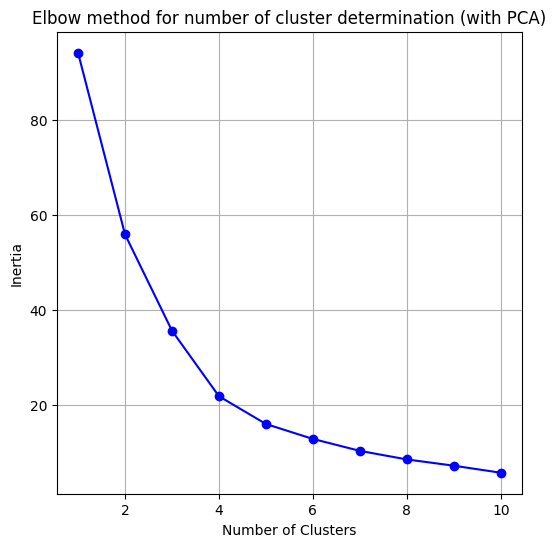

In [73]:
# Preparar os dados
X = df_grouped[[
    'temperature',
    'precipitation',
    'relative_humidity',
    'residencial comercial servicos',
    'espaco verde urbano'
]].iloc[:, :].values  # Selecionar todas as colunas do conjunto de dados

# Normalizar os dados
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

# Aplicar PCA para redução de dimensionalidade
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)

# Encontrar o número ideal de clusters utilizando o método Elbow
n_clusters = range(1, 11)
inertias = []
for n in n_clusters:
    kmeans = KMeans(n_clusters=n, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_pca)
    inertias.append(kmeans.inertia_)

# Plotar o gráfico do método Elbow
plt.subplots(figsize=(6, 6))
plt.plot(n_clusters, inertias, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow method for number of cluster determination (with PCA)')
plt.grid()
plt.savefig(f'../figures/elbow_method.png', dpi=300, bbox_inches="tight")
plt.show()

[[ 0.51030556 -1.17503283]
 [-0.99293529  0.06065479]
 [ 0.82870247  1.90345918]
 [ 3.33403624 -0.5134275 ]]


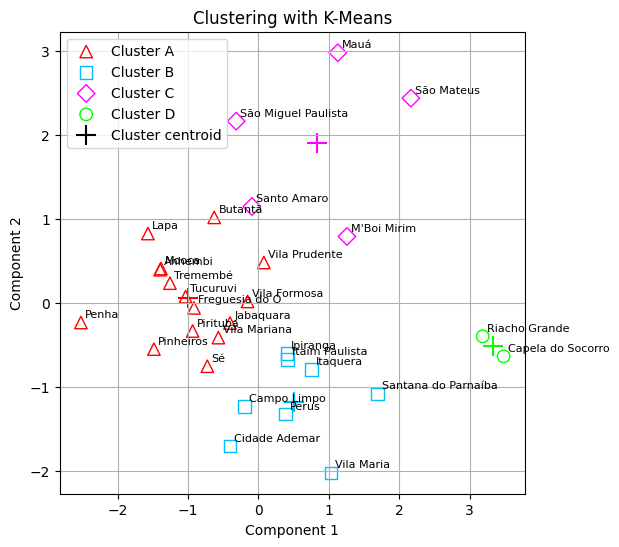

In [74]:
# Clusterizar os dados com o número de clusters escolhido
k = 4  # Número de clusters escolhido
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
y_kmeans = kmeans.fit_predict(X_pca)

centroids = kmeans.cluster_centers_
print(centroids)

kmeans_output = pd.DataFrame(
    data=X_pca,
    index=df_grouped.station
    )

kmeans_output["cluster"] = y_kmeans

# Plotar os clusters encontrados
plt.subplots(figsize=(6, 6))

plt.scatter(
    kmeans_output[kmeans_output.cluster == 1][0],
    kmeans_output[kmeans_output.cluster == 1][1],
    marker="^",
    s=80,
    label='Cluster A',
    facecolors='none',
    edgecolors='red'
)

plt.scatter(
    kmeans_output[kmeans_output.cluster == 0][0], 
    kmeans_output[kmeans_output.cluster == 0][1], 
    marker="s", 
    s=80, 
    label='Cluster B',
    facecolors='none',
    edgecolors='deepskyblue'
)

plt.scatter(
    kmeans_output[kmeans_output.cluster == 2][0],
    kmeans_output[kmeans_output.cluster == 2][1],
    marker="D",
    s=80,
    label='Cluster C',
    facecolors='none',
    edgecolors='magenta'
)

plt.scatter(
    kmeans_output[kmeans_output.cluster == 3][0],
    kmeans_output[kmeans_output.cluster == 3][1],
    marker="o",
    s=80,
    label='Cluster D',
    facecolors='none',
    edgecolors='lime'
)

for idx, row in kmeans_output.iterrows(): 
    plt.text(row[0]+.06, row[1]+.06, idx, size=8)

plt.scatter(centroids[0][0], centroids[0][1], marker="+", s=200, c='black', label='Cluster centroid')
plt.scatter(centroids[0][0], centroids[0][1], marker="+", s=200, c='deepskyblue', label='_nolegend_')
plt.scatter(centroids[1][0], centroids[1][1], marker="+", s=200, c='red', label='_nolegend_')
plt.scatter(centroids[2][0], centroids[2][1], marker="+", s=200, c='magenta', label='_nolegend_')
plt.scatter(centroids[3][0], centroids[3][1], marker="+", s=200, c='lime', label='_nolegend_')


plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Clustering with K-Means')
plt.grid()
plt.legend(prop={'size': 10})
plt.savefig(f'../figures/clusters.png', dpi=300, bbox_inches="tight")
plt.show()

In [75]:
df_grouped = df_grouped.merge(
    kmeans_output.reset_index()[["station", "cluster"]],
    on="station"
)

df_grouped['cluster'] = df_grouped['cluster'].map({
    0: "B", 
    1: "A", 
    2: "C",
    3: "D"
})

df_grouped

,station,precipitation,temperature,relative_humidity,residencial comercial servicos,espaco verde urbano,lat,lon,cluster
0,Anhembi,1.860340,20.799166,75.495413,10.117707,2.487090,-23.518626,-46.643757,A
1,Butantã,2.031074,20.445426,80.674328,0.000000,0.000000,-23.554516,-46.726570,A
2,Campo Limpo,1.704243,20.769885,78.881693,58.311786,0.000000,-23.658180,-46.767490,B
3,Capela do Socorro,1.739865,18.893560,89.509712,90.974771,0.000000,-23.781133,-46.725217,D
4,Cidade Ademar,1.771956,20.601012,76.677048,87.173176,0.000000,-23.667670,-46.674160,B
5,Freguesia do Ó,2.104188,20.627032,79.192017,56.043464,0.000000,-23.477060,-46.665370,A
6,Ipiranga,1.879577,20.173128,81.060309,68.747963,0.393253,-23.632978,-46.583518,B
7,Itaim Paulista,1.808285,20.263566,81.015760,57.869498,0.000000,-23.490670,-46.435990,B
8,Itaquera,1.845294,19.936505,81.154465,74.067394,0.000000,-23.552301,-46.446110,B
9,Jabaquara,2.063883,19.194426,73.223958,65.300791,0.000000,-23.650814,-46.646581,A


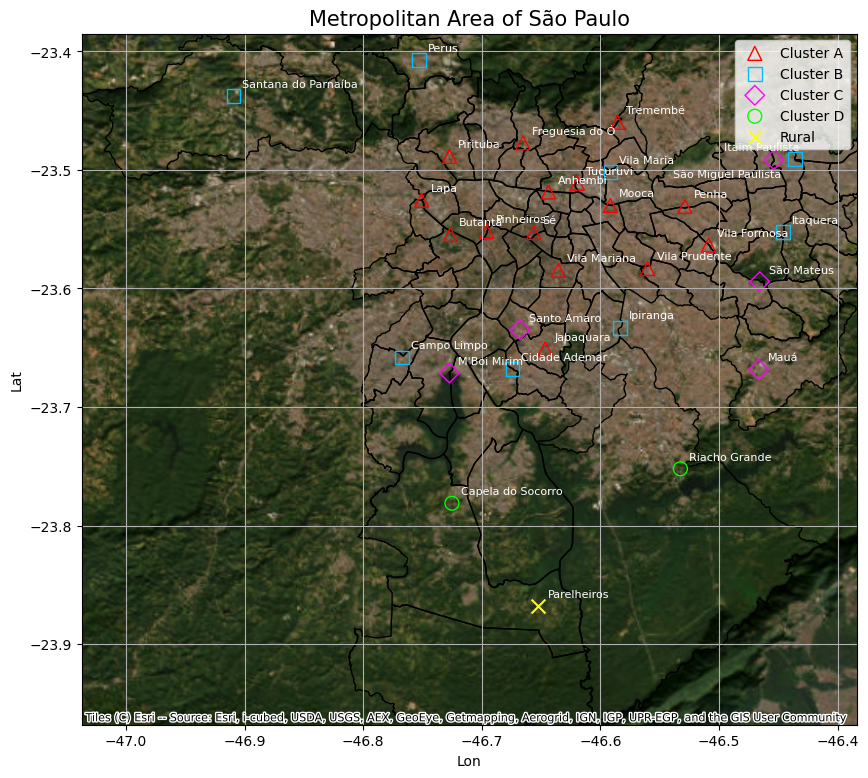

In [76]:
import contextily as ctx

masp_cities = [
    "Mauá",  
    "São Bernardo do Campo",  
    "Santana de Parnaíba", 
]

epsg = 4326

sp = gpd.read_file('SP_Municipios_2022')
sp = sp.to_crs(f'EPSG:{epsg}')
sp_masp_cities = sp[sp.NM_MUN.isin(masp_cities)]

sp_cidade = gpd.read_file('LAYER_DISTRITO')
sp_cidade = sp_cidade.to_crs(f'EPSG:{epsg}')

weather_stations_cluster_A = list(df_grouped[df_grouped.cluster == "A"][["lat", "lon"]].itertuples(index=False, name=None))
weather_stations_cluster_B = list(df_grouped[df_grouped.cluster == "B"][["lat", "lon"]].itertuples(index=False, name=None))
weather_stations_cluster_C = list(df_grouped[df_grouped.cluster == "C"][["lat", "lon"]].itertuples(index=False, name=None))
weather_stations_cluster_D = list(df_grouped[df_grouped.cluster == "D"][["lat", "lon"]].itertuples(index=False, name=None))

# Crie um GeoDataFrame com as coordenadas das estações meteorológicas e atribua o CRS (EPSG: 4326)
weather_stations_gdf_cluster_A = gpd.GeoDataFrame(geometry=gpd.points_from_xy([x[1] for x in weather_stations_cluster_A], [x[0] for x in weather_stations_cluster_A]), crs=f"EPSG:{epsg}")
weather_stations_gdf_cluster_B = gpd.GeoDataFrame(geometry=gpd.points_from_xy([x[1] for x in weather_stations_cluster_B], [x[0] for x in weather_stations_cluster_B]), crs=f"EPSG:{epsg}")
weather_stations_gdf_cluster_C = gpd.GeoDataFrame(geometry=gpd.points_from_xy([x[1] for x in weather_stations_cluster_C], [x[0] for x in weather_stations_cluster_C]), crs=f"EPSG:{epsg}")
weather_stations_gdf_cluster_D = gpd.GeoDataFrame(geometry=gpd.points_from_xy([x[1] for x in weather_stations_cluster_D], [x[0] for x in weather_stations_cluster_D]), crs=f"EPSG:{epsg}")

# Converta as coordenadas das estações meteorológicas para o sistema de coordenadas Web Mercator (EPSG: 3857)
weather_stations_gdf_cluster_A_projected = weather_stations_gdf_cluster_A.to_crs(epsg=epsg)
weather_stations_gdf_cluster_B_projected = weather_stations_gdf_cluster_B.to_crs(epsg=epsg)
weather_stations_gdf_cluster_C_projected = weather_stations_gdf_cluster_C.to_crs(epsg=epsg)
weather_stations_gdf_cluster_D_projected = weather_stations_gdf_cluster_D.to_crs(epsg=epsg)

# Plote o mapa da RMSP
fig, ax = plt.subplots(figsize=(10, 10))
sp_masp_cities.plot(ax=ax, edgecolor='black', facecolor='none')
sp_cidade.plot(ax=ax, edgecolor='black', facecolor='none')

# Adicione a imagem de satélite usando o Contextily
ctx.add_basemap(
    ax, 
    source=ctx.providers.Esri.WorldImagery, 
    # zoom="auto", 
    crs=f"EPSG:{epsg}"
)

# Plote os pontos das estações meteorológicas
ax.scatter(
    weather_stations_gdf_cluster_A_projected.geometry.x, 
    weather_stations_gdf_cluster_A_projected.geometry.y,
    marker="^",
    s=100,
    label='Cluster A',
    facecolors='none',
    edgecolors='red'
)

ax.scatter(
    weather_stations_gdf_cluster_B_projected.geometry.x, 
    weather_stations_gdf_cluster_B_projected.geometry.y, 
    marker="s",
    s=100,
    label='Cluster B',
    facecolors='none',
    edgecolors='deepskyblue'
)

ax.scatter(
    weather_stations_gdf_cluster_C_projected.geometry.x, 
    weather_stations_gdf_cluster_C_projected.geometry.y,
    marker="D",
    s=100,
    label='Cluster C',
    facecolors='none',
    edgecolors='magenta'
)

ax.scatter(
    weather_stations_gdf_cluster_D_projected.geometry.x, 
    weather_stations_gdf_cluster_D_projected.geometry.y,
    marker="o",
    s=100,
    label='Cluster D',
    facecolors='none',
    edgecolors='lime'
)

# Plote da estação de referência rural
ax.scatter(
    -46.652222, 
    -23.867778, 
    marker="x",
    s=100,
    label='Rural',
    color='yellow'
)

# Ajuste os limites do gráfico para mostrar apenas a RMSP
ax.set_xlim(sp_masp_cities.bounds.minx.min(), sp_masp_cities.bounds.maxx.max())
ax.set_ylim(sp_masp_cities.bounds.miny.min(), sp_masp_cities.bounds.maxy.max())

# Adicione títulos e rótulos
ax.set_title('Metropolitan Area of São Paulo', fontdict={'fontsize': 15})
ax.set_xlabel('Lon')
ax.set_ylabel('Lat')

# Adicione a legenda
ax.legend()
ax.grid()

for idx, row in stations.set_index('station').iterrows(): 
    if idx not in ['Itaim Paulista', 'São Miguel Paulista']:
        plt.text(
            row['lon']+0.0075, 
            row['lat']+0.0075, 
            idx, 
            size=8, 
            color='white'
        )
    elif idx == 'Itaim Paulista':
        plt.text(
            row['lon']-0.06, 
            row['lat']+0.0075, 
            idx, 
            size=8, 
            color='white'
        )
    elif idx == 'São Miguel Paulista':
        plt.text(
            row['lon']-0.085, 
            row['lat']-0.015, 
            idx, 
            size=8, 
            color='white'
        )

# Exiba o gráfico
plt.savefig(f'../figures/masp_clusters.png', dpi=300, bbox_inches="tight")
plt.show()

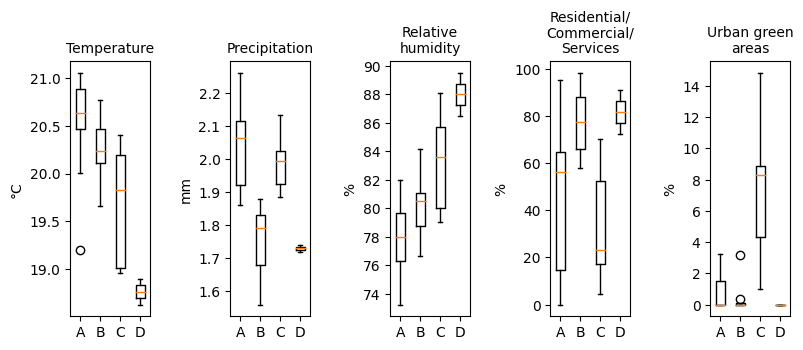

In [77]:
df_grouped_boxplot = df_grouped[[
    'temperature',
    'precipitation',
    'relative_humidity',
    'residencial comercial servicos',
    'espaco verde urbano',
    'cluster'
]]

df_grouped_boxplot.columns = [
    "Temperature",  
    "Precipitation",
    "Relative humidity",
    'Residential/Commercial/Services',
    'Urban green areas',
    "cluster"
]

vars = list(df_grouped_boxplot.drop("cluster", axis=1).columns)

ncols = len(df_grouped_boxplot.drop(columns=['cluster'], axis=1).columns)
fig, axs = plt.subplots(nrows=1, ncols=ncols, figsize=(8, 3))
p = 0

for i in vars:
    # Lista com os grupos de dados
    
    dados = [
        df_grouped_boxplot[df_grouped_boxplot.cluster == "A"][i], 
        df_grouped_boxplot[df_grouped_boxplot.cluster == "B"][i], 
        df_grouped_boxplot[df_grouped_boxplot.cluster == "C"][i],
        df_grouped_boxplot[df_grouped_boxplot.cluster == "D"][i]
        ]

    # Nomes dos grupos
    nomes_grupos = [
        'A', 
        'B', 
        'C',
        'D'
    ]

    # Criar o boxplot
    axs[p].boxplot(dados, labels=nomes_grupos)

    # Adicionar título e rótulos dos eixos
    parameter = i

    if parameter == "Relative humidity":
        parameter = "Relative\nhumidity"
    elif parameter == "Residential/Commercial/Services":
        parameter = "Residential/\nCommercial/\nServices"
    elif parameter == "Urban green areas":
        parameter = "Urban green\nareas"
    elif parameter == "Daily max temperature":
        parameter = "Daily max\ntemperature"

    axs[p].set_title(f'{parameter}', fontdict={'fontsize': 10})
    axs[p].set_xlabel('')
    
    if parameter == "Precipitation":
        ylabel = "mm"
    elif parameter == "Temperature":
        ylabel = "°C"
    else:
        ylabel = "%"
    
    axs[p].set_ylabel(ylabel)

    p += 1

fig.subplots_adjust(
    left=0.08, 
    right=0.98, 
    bottom=0.05, 
    top=0.9,
    wspace=1
)

plt.savefig(f'../figures/boxplot_clusters_parameters.png', dpi=300, bbox_inches="tight")
plt.show()

In [78]:
# df_grouped_boxplot.drop(columns=["cluster"]).describe()
df_grouped_boxplot.groupby("cluster")["Temperature"].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
A,15.0,20.571047,0.483310,19.194426,20.468620,20.638806,20.886306,21.056623
B,8.0,20.253852,0.354389,19.657486,20.113972,20.236681,20.464831,20.769885
C,5.0,19.678728,0.669350,18.952924,19.008897,19.831647,20.197389,20.402786
D,2.0,18.758469,0.191048,18.623377,18.690923,18.758469,18.826014,18.893560


In [79]:
# df_grouped_boxplot.drop(columns=["cluster"]).describe()
df_grouped_boxplot.groupby("cluster")["Precipitation"].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
A,15.0,2.037960,0.120006,1.860340,1.922094,2.063883,2.114699,2.260787
B,8.0,1.749910,0.116649,1.558484,1.679512,1.790120,1.830915,1.879577
C,5.0,1.991237,0.096236,1.883241,1.924789,1.992373,2.023359,2.132425
D,2.0,1.729399,0.014801,1.718933,1.724166,1.729399,1.734632,1.739865


In [80]:
# df_grouped_boxplot.drop(columns=["cluster"]).describe()
df_grouped_boxplot.groupby("cluster")["Relative humidity"].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
A,15.0,77.832529,2.512255,73.223958,76.309829,78.004925,79.678928,81.949849
B,8.0,80.157266,2.255306,76.677048,78.730623,80.539014,81.083848,84.129172
C,5.0,83.282732,3.798158,79.027217,80.004422,83.627063,85.676582,88.078377
D,2.0,88.010256,2.120552,86.510799,87.260528,88.010256,88.759984,89.509712


In [81]:
# df_grouped_boxplot.drop(columns=["cluster"]).describe()
df_grouped_boxplot.groupby("cluster")["Residential/Commercial/Services"].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
A,15.0,46.048712,32.015536,0.000000,14.637652,56.043464,64.837015,95.115602
B,8.0,76.887586,14.757541,57.869498,66.138918,77.476503,87.846560,98.178544
C,5.0,33.563243,26.995316,4.544428,17.397593,23.144509,52.500288,70.229395
D,2.0,81.696689,13.121190,72.418606,77.057648,81.696689,86.335730,90.974771


In [82]:
# df_grouped_boxplot.drop(columns=["cluster"]).describe()
df_grouped_boxplot.groupby("cluster")["Urban green areas"].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
A,15.0,0.859863,1.195989,0.000000,0.000000,0.000000,1.545430,3.254237
B,8.0,0.449294,1.120379,0.000000,0.000000,0.000000,0.098313,3.201096
C,5.0,7.460914,5.214985,0.992946,4.319017,8.303517,8.849904,14.839185
D,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [83]:
# getting preprocessed data
df_full_0 = []
df_full_1 = []
df_full_2 = []
df_full_3 = []
prefix_objs = s3_resource.Bucket("cge").objects.filter(Prefix="processed")
keys = [obj.key for obj in prefix_objs]
for key in keys[1:]:
    obj = s3_client.get_object(Bucket="cge", Key=key)
    df = pd.read_csv(io.BytesIO(obj["Body"].read()))
    df = remove_outliers(df=df, feature='temperature_lag_1H')
    
    try:
        df_2 = df[[
            "timestamp",
            "station_name",
            "precipitation_lag_1H",
            "temperature_lag_1H",
            "relative_humidity_lag_1H",
            "pressure_lag_1H",
            "wind_velocity_x_lag_1H",
            "wind_velocity_y_lag_1H",
            "wind_blow_x_lag_1H",
            "wind_blow_y_lag_1H"
        ]]
    except:
        df_2 = df[[
            "timestamp",
            "station_name",
            "precipitation_lag_1H",
            "temperature_lag_1H",
            "relative_humidity_lag_1H",
            "pressure_lag_1H"
        ]]
    

    if df_2.station_name.unique()[0] in list(df_grouped[df_grouped.cluster == "A"].station): 
        df_full_0.append(df_2)
    if df_2.station_name.unique()[0] in list(df_grouped[df_grouped.cluster == "B"].station): 
        df_full_1.append(df_2)
    if df_2.station_name.unique()[0] in list(df_grouped[df_grouped.cluster == "C"].station): 
        df_full_2.append(df_2)
    if df_2.station_name.unique()[0] in list(df_grouped[df_grouped.cluster == "D"].station): 
        df_full_3.append(df_2)

df_cluster_A = pd.concat(df_full_0)
df_cluster_A.to_csv("df_cluster_A.csv", index=False)

df_cluster_B = pd.concat(df_full_1)
df_cluster_B.to_csv("df_cluster_B.csv", index=False)

df_cluster_C = pd.concat(df_full_2)
df_cluster_C.to_csv("df_cluster_C.csv", index=False)

df_cluster_D = pd.concat(df_full_3)
df_cluster_D.to_csv("df_cluster_D.csv", index=False)

In [84]:
df_cluster_A = pd.read_csv("df_cluster_A.csv")
df_cluster_B = pd.read_csv("df_cluster_B.csv")
df_cluster_C = pd.read_csv("df_cluster_C.csv")
df_cluster_D = pd.read_csv("df_cluster_D.csv")

In [85]:
df_cluster_A = df_cluster_A.merge(df_parelheiros, on="timestamp")
df_cluster_B = df_cluster_B.merge(df_parelheiros, on="timestamp")
df_cluster_C = df_cluster_C.merge(df_parelheiros, on="timestamp")
df_cluster_D = df_cluster_D.merge(df_parelheiros, on="timestamp")

In [86]:
def revert_lag(df, cols):
    df[cols] = df[cols].shift(-1)
    return df

In [87]:
def apply_revert_lags(df, cols):
    dfs = []
    for i in df.station_name.unique():
        dfi = df[df.station_name == i]
        dfi = revert_lag(dfi, cols)
        dfs.append(dfi)
    return pd.concat(dfs)

In [88]:
cols = [
    "precipitation_lag_1H",
    "temperature_lag_1H",
    "relative_humidity_lag_1H",
    "pressure_lag_1H",
    "wind_velocity_x_lag_1H",
    "wind_velocity_y_lag_1H",
    "wind_blow_x_lag_1H",
    "wind_blow_y_lag_1H"
    ]


df_cluster_A = apply_revert_lags(df=df_cluster_A, cols=cols)
df_cluster_B = apply_revert_lags(df=df_cluster_B, cols=cols)
df_cluster_C = apply_revert_lags(df=df_cluster_C, cols=cols)
df_cluster_D = apply_revert_lags(df=df_cluster_D, cols=cols)

/tmp/ipykernel_1660/1133768500.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[cols] = df[cols].shift(-1)
/tmp/ipykernel_1660/1133768500.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[cols] = df[cols].shift(-1)
/tmp/ipykernel_1660/1133768500.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

In [89]:
def calculate_uhii(df):
    df['uhii'] = df.temperature_lag_1H - df.temperature_rural
    return df

In [90]:
df_cluster_A = calculate_uhii(df=df_cluster_A)
df_cluster_B = calculate_uhii(df=df_cluster_B)
df_cluster_C = calculate_uhii(df=df_cluster_C)
df_cluster_D = calculate_uhii(df=df_cluster_D)

In [91]:
df_cluster_A_2 = df_cluster_A[df_cluster_A.uhii >= 0]
df_cluster_B_2 = df_cluster_B[df_cluster_B.uhii >= 0]
df_cluster_C_2 = df_cluster_C[df_cluster_C.uhii >= 0]
df_cluster_D_2 = df_cluster_D[df_cluster_D.uhii >= 0]

df_cluster_A_2['timestamp'] = pd.to_datetime(df_cluster_A_2['timestamp'])
df_cluster_B_2['timestamp'] = pd.to_datetime(df_cluster_B_2['timestamp'])
df_cluster_C_2['timestamp'] = pd.to_datetime(df_cluster_C_2['timestamp'])
df_cluster_D_2['timestamp'] = pd.to_datetime(df_cluster_D_2['timestamp'])

def periodo_dia(x):
  if x >=6 and x < 18:
    return 'Day'
  else:
    return 'Night'

df_cluster_A_2['hour'] = df_cluster_A_2['timestamp'].dt.hour
df_cluster_A_2['day_period'] = df_cluster_A_2['hour'].apply(periodo_dia)

df_cluster_B_2['hour'] = df_cluster_B_2['timestamp'].dt.hour
df_cluster_B_2['day_period'] = df_cluster_B_2['hour'].apply(periodo_dia)

df_cluster_C_2['hour'] = df_cluster_C_2['timestamp'].dt.hour
df_cluster_C_2['day_period'] = df_cluster_C_2['hour'].apply(periodo_dia)

df_cluster_D_2['hour'] = df_cluster_D_2['timestamp'].dt.hour
df_cluster_D_2['day_period'] = df_cluster_D_2['hour'].apply(periodo_dia)

def seasons(x):
  if x in [1, 2, 3]:
    return 'Summer'
  elif x in [4, 5, 6]:
    return 'Autumn'
  elif x in [7, 8, 9]:
    return 'Winter'
  elif x in [10, 11, 12]:
    return 'Spring'

df_cluster_A_2['month'] = df_cluster_A_2['timestamp'].dt.month
df_cluster_A_2['seasons'] = df_cluster_A_2.month.apply(seasons)
df_cluster_A_2['cluster'] = 'A'

df_cluster_B_2['month'] = df_cluster_B_2['timestamp'].dt.month
df_cluster_B_2['seasons'] = df_cluster_B_2.month.apply(seasons)
df_cluster_B_2['cluster'] = 'B'

df_cluster_C_2['month'] = df_cluster_C_2['timestamp'].dt.month
df_cluster_C_2['seasons'] = df_cluster_C_2.month.apply(seasons)
df_cluster_C_2['cluster'] = 'C'

df_cluster_D_2['month'] = df_cluster_D_2['timestamp'].dt.month
df_cluster_D_2['seasons'] = df_cluster_D_2.month.apply(seasons)
df_cluster_D_2['cluster'] = 'D'

df_uhii = pd.concat([
  df_cluster_A_2,
  df_cluster_B_2,
  df_cluster_C_2,
  df_cluster_D_2
])

/tmp/ipykernel_1660/3741971537.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster_A_2['timestamp'] = pd.to_datetime(df_cluster_A_2['timestamp'])
/tmp/ipykernel_1660/3741971537.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster_B_2['timestamp'] = pd.to_datetime(df_cluster_B_2['timestamp'])
/tmp/ipykernel_1660/3741971537.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [92]:
def group_data(df):
    uhi_hour = df[['seasons', 'hour', 'uhii']]
    uhi_hour_grouped = uhi_hour.groupby(['seasons', 'hour']).agg(['mean', 'std'])
    uhi_hour_grouped = uhi_hour_grouped.reset_index()
    return uhi_hour_grouped

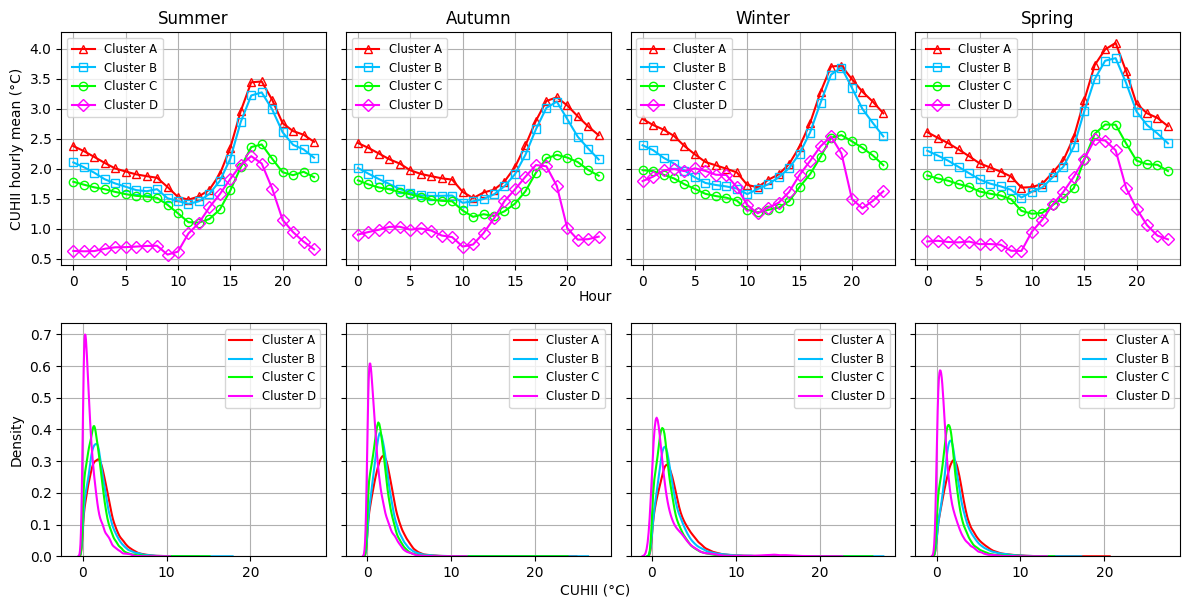

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt

def uhii_clusters(df):
    fig, axs = plt.subplots(2, 4, figsize=(12,6), sharex='row', sharey='row')
    fig.subplots_adjust(bottom=0.2, hspace=1)

    estacoes = ['Summer', 'Autumn', 'Winter', 'Spring'] 

    idx = 0
    cluster_A_grouped = group_data(df[df.cluster == 'A'])
    cluster_B_grouped = group_data(df[df.cluster == 'B'])
    cluster_C_grouped = group_data(df[df.cluster == 'C'])
    cluster_D_grouped = group_data(df[df.cluster == 'D'])
    axs[0, idx].set_ylabel('CUHII hourly mean (°C)', size=10)
    for i in estacoes:
        data_slice_cluster_A = cluster_A_grouped[cluster_A_grouped['seasons'] == i]
        data_slice_cluster_B = cluster_B_grouped[cluster_B_grouped['seasons'] == i] 
        data_slice_cluster_C = cluster_C_grouped[cluster_C_grouped['seasons'] == i]
        data_slice_cluster_D = cluster_D_grouped[cluster_D_grouped['seasons'] == i] 
        axs[0, idx].plot(data_slice_cluster_A['hour'], data_slice_cluster_A[('uhii', 'mean')], label='Cluster A', marker='^', color='red', markerfacecolor='none', markeredgecolor='red')
        axs[0, idx].plot(data_slice_cluster_B['hour'], data_slice_cluster_B[('uhii', 'mean')], label='Cluster B', marker='s', color='deepskyblue', markerfacecolor='none', markeredgecolor='deepskyblue')
        axs[0, idx].plot(data_slice_cluster_C['hour'], data_slice_cluster_C[('uhii', 'mean')], label='Cluster C', marker='o', color='lime', markerfacecolor='none', markeredgecolor='lime')
        axs[0, idx].plot(data_slice_cluster_D['hour'], data_slice_cluster_D[('uhii', 'mean')], label='Cluster D', marker='D', color='magenta', markerfacecolor='none', markeredgecolor='magenta')
        axs[0, idx].set_title(i)
        axs[0, idx].grid()
        axs[0, idx].set_xlabel(' ')
        axs[0, idx].legend(fontsize='small')
        idx += 1

    idx = 0
    for i in estacoes:  
        sns.kdeplot(df[(df['seasons'] == i) & (df['cluster'] == 'A')]['uhii'], label='Cluster A', color='red', ax=axs[1, idx])
        sns.kdeplot(df[(df['seasons'] == i) & (df['cluster'] == 'B')]['uhii'], label='Cluster B', color='deepskyblue', ax=axs[1, idx])
        sns.kdeplot(df[(df['seasons'] == i) & (df['cluster'] == 'C')]['uhii'], label='Cluster C', color='lime', ax=axs[1, idx])
        sns.kdeplot(df[(df['seasons'] == i) & (df['cluster'] == 'D')]['uhii'], label='Cluster D', color='magenta', ax=axs[1, idx])
        axs[1, idx].grid()
        axs[1, idx].set_xlabel('')
        axs[1, idx].legend(fontsize='small')
        idx += 1

    # Adiciona rótulos de eixo x centralizados
    fig.text(0.5, 0.49, 'Hour', ha='center')
    fig.text(0.5, 0.0, 'CUHII (°C)', ha='center')

    plt.tight_layout()
    plt.savefig(f'../figures/uhii_clusters.png', dpi=300, bbox_inches="tight")
    plt.show()


uhii_clusters(df_uhii)

In [94]:
uhi_hour = df_uhii[['cluster', 'seasons', 'hour', 'uhii', 'precipitation_lag_1H', 'temperature_lag_1H', 'relative_humidity_lag_1H']]
uhi_hour = uhi_hour.rename(columns={'precipitation_lag_1H': 'precipitation', 'temperature_lag_1H': 'temperature', 'relative_humidity_lag_1H': 'relative_humidity'})
uhi_hour_grouped = uhi_hour.groupby(['cluster', 'seasons', 'hour'])['uhii'].mean()
uhi_hour_grouped = uhi_hour_grouped.reset_index()

In [95]:
uhi_hour_grouped[(uhi_hour_grouped.cluster == 'A') & (uhi_hour_grouped.seasons == 'Summer')].set_index('cluster')

,seasons,hour,uhii
cluster,,,
A,Summer,0,2.373788
A,Summer,1,2.290960
A,Summer,2,2.193325
A,Summer,3,2.093421
A,Summer,4,2.000736
A,Summer,5,1.950264
A,Summer,6,1.902672
A,Summer,7,1.872738
A,Summer,8,1.845905


In [96]:
uhi_hour_grouped[(uhi_hour_grouped.cluster == 'B') & (uhi_hour_grouped.seasons == 'Summer')].set_index('cluster')

,seasons,hour,uhii
cluster,,,
B,Summer,0,2.101633
B,Summer,1,2.022952
B,Summer,2,1.930512
B,Summer,3,1.821060
B,Summer,4,1.751218
B,Summer,5,1.696660
B,Summer,6,1.640454
B,Summer,7,1.620977
B,Summer,8,1.655705


In [97]:
uhi_hour_grouped[(uhi_hour_grouped.cluster == 'C') & (uhi_hour_grouped.seasons == 'Summer')].set_index('cluster')

,seasons,hour,uhii
cluster,,,
C,Summer,0,1.779195
C,Summer,1,1.731434
C,Summer,2,1.686926
C,Summer,3,1.654293
C,Summer,4,1.610719
C,Summer,5,1.572851
C,Summer,6,1.544934
C,Summer,7,1.531355
C,Summer,8,1.510064


In [98]:
uhi_hour_grouped[(uhi_hour_grouped.cluster == 'D') & (uhi_hour_grouped.seasons == 'Summer')].set_index('cluster')

,seasons,hour,uhii
cluster,,,
D,Summer,0,0.626733
D,Summer,1,0.620526
D,Summer,2,0.624173
D,Summer,3,0.662261
D,Summer,4,0.687018
D,Summer,5,0.689805
D,Summer,6,0.699345
D,Summer,7,0.709262
D,Summer,8,0.713142


In [111]:
df_uhii_analysis = df_uhii.rename(columns={"temperature_lag_1H": "temperature", "relative_humidity_lag_1H": "relative_humidity", "precipitation_lag_1H": "precipitation", "station_name": "station"})
df_uhii_analysis = df_uhii_analysis.groupby(['cluster', 'station', 'seasons'])[['temperature', 'relative_humidity', 'precipitation', 'temperature_rural', 'uhii']].mean().reset_index()
df_uhii_analysis = df_uhii_analysis.merge(df_grouped[['cluster', "station", "residencial comercial servicos", "espaco verde urbano"]], on=["cluster", "station"])
df_uhii_analysis = df_uhii_analysis[["cluster", "station", "seasons", "uhii", "temperature", "relative_humidity", "precipitation", "residencial comercial servicos", "espaco verde urbano"]]
df_uhii_analysis.columns = ["cluster", "station", "seasons", "CUHII (°C)", "Temperature (°C)", "Relative humidity (%)", "Precipitation (mm)", "Residential\ncommercial\nservices (%)", "Urban\ngreen\nspace (%)"]

In [112]:
summer = df_uhii_analysis[df_uhii_analysis.seasons == "Summer"].drop(columns=["station", "seasons"])
autumn = df_uhii_analysis[df_uhii_analysis.seasons == "Autumn"].drop(columns=["station", "seasons"])
winter = df_uhii_analysis[df_uhii_analysis.seasons == "Winter"].drop(columns=["station", "seasons"])
spring = df_uhii_analysis[df_uhii_analysis.seasons == "Spring"].drop(columns=["station", "seasons"])

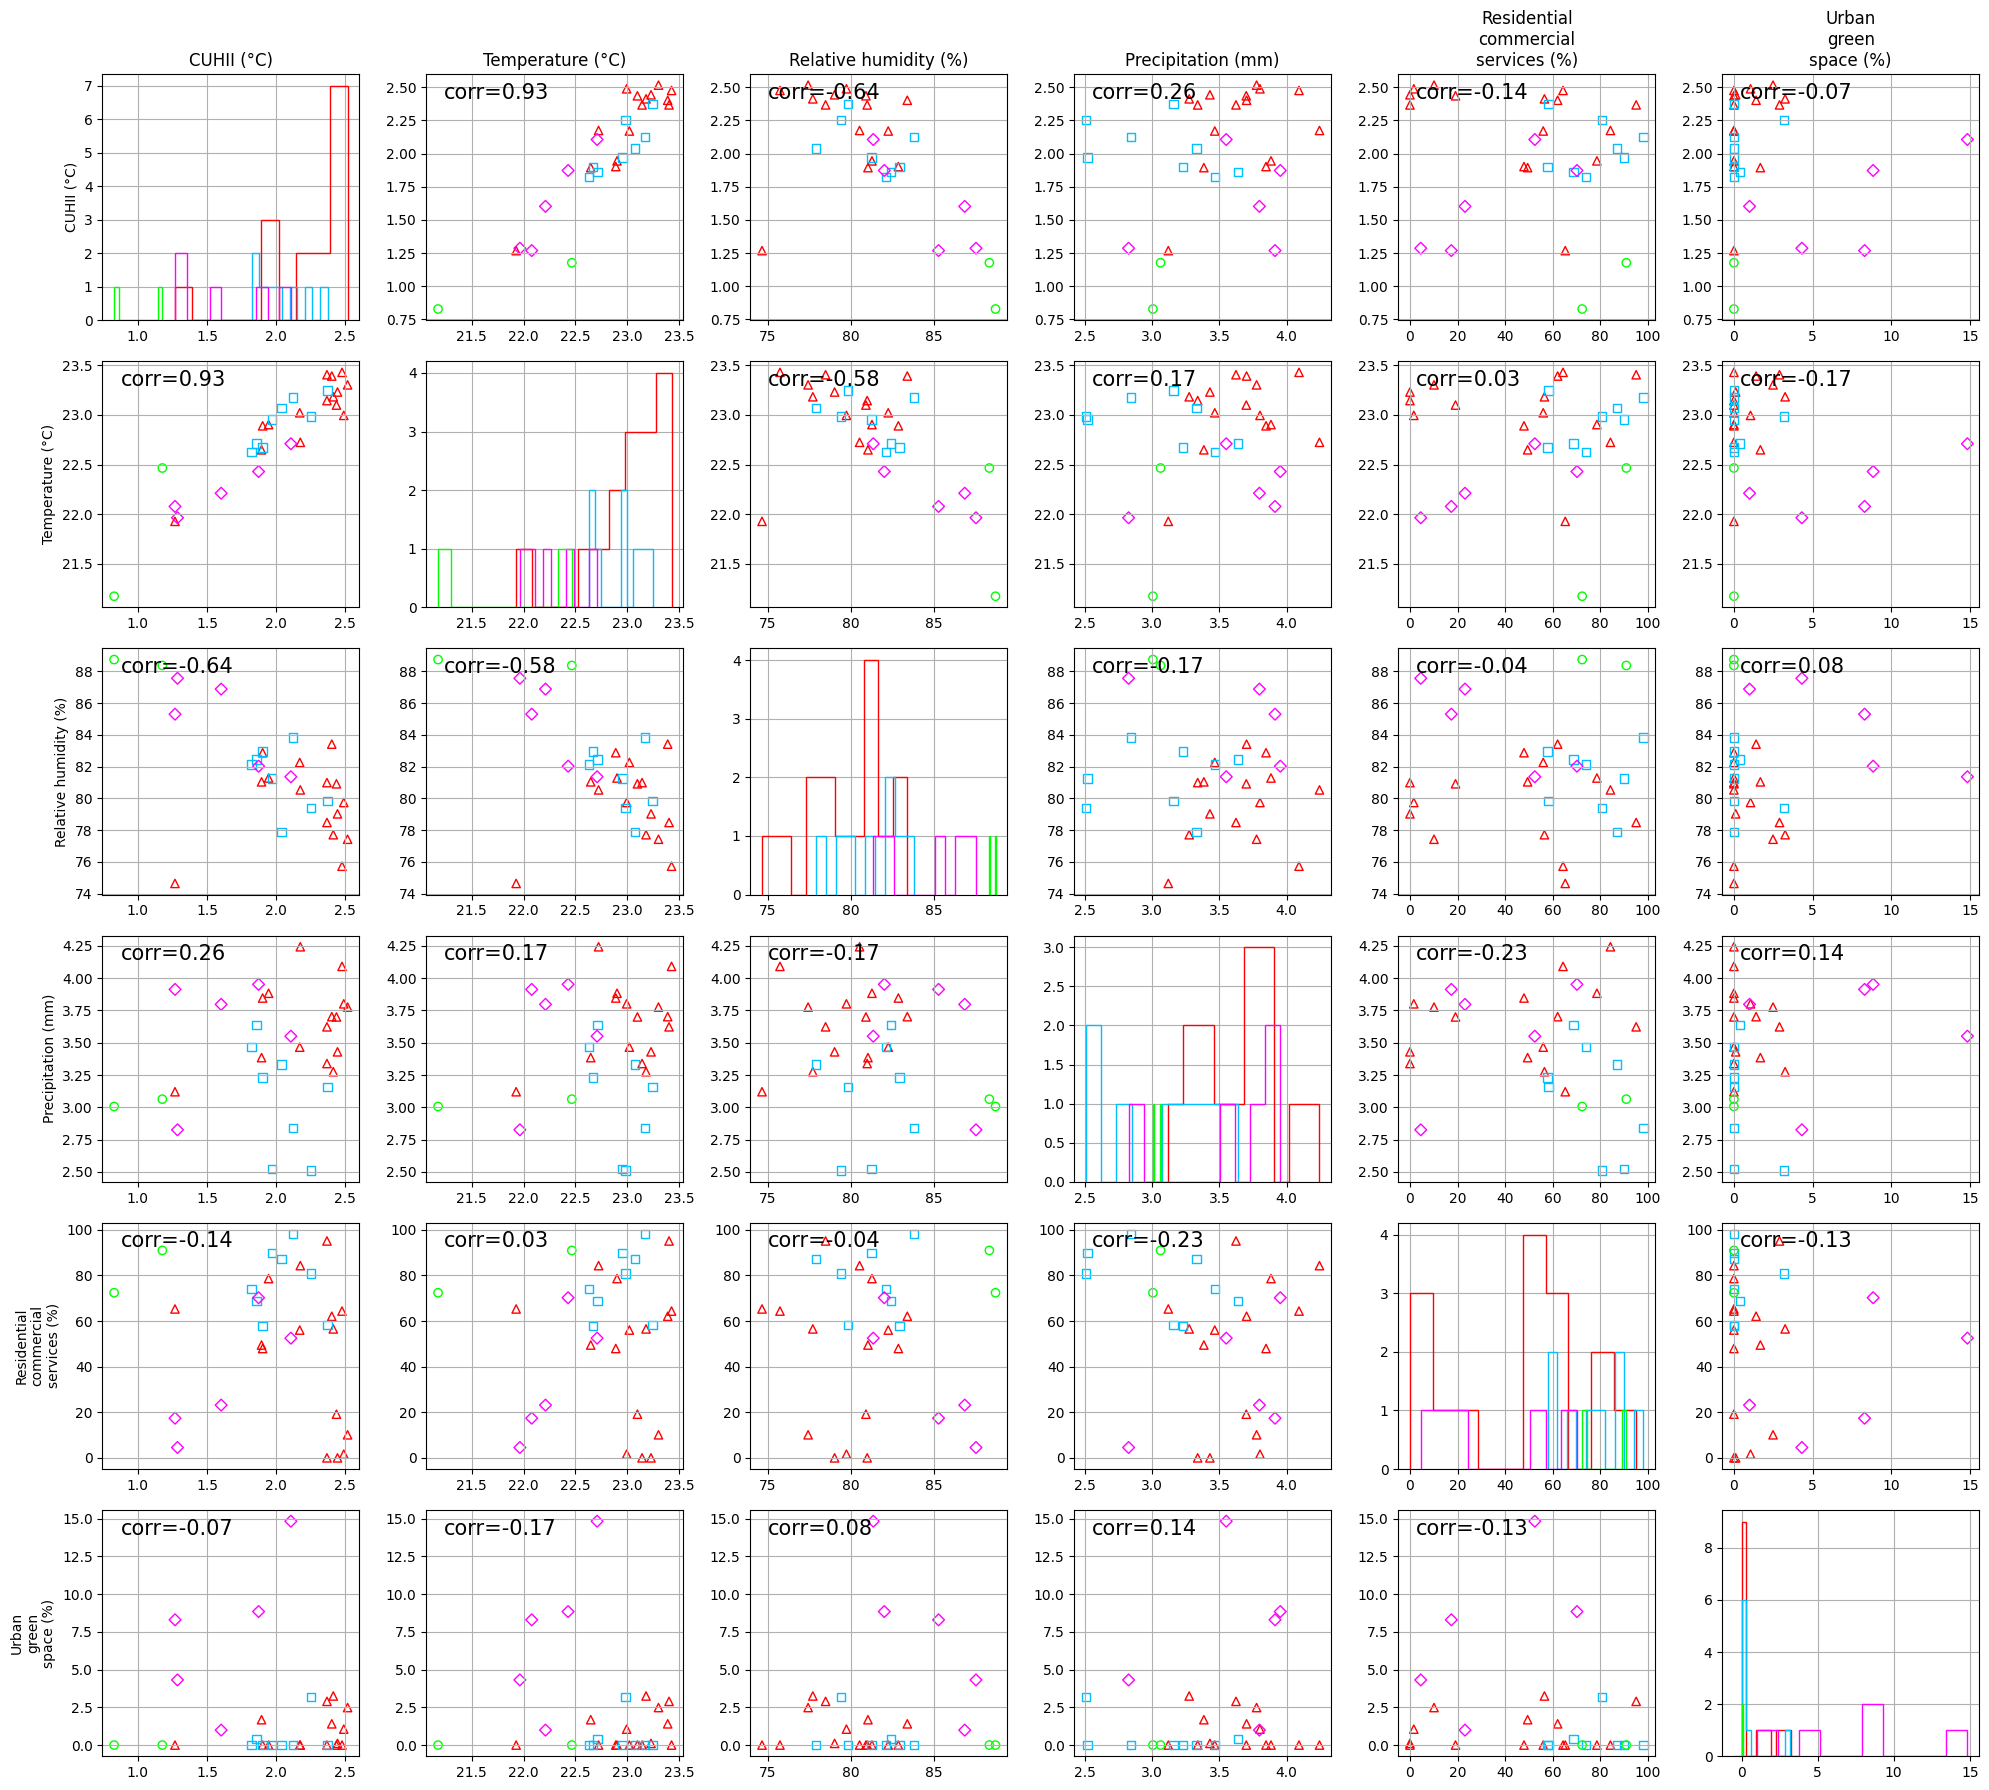

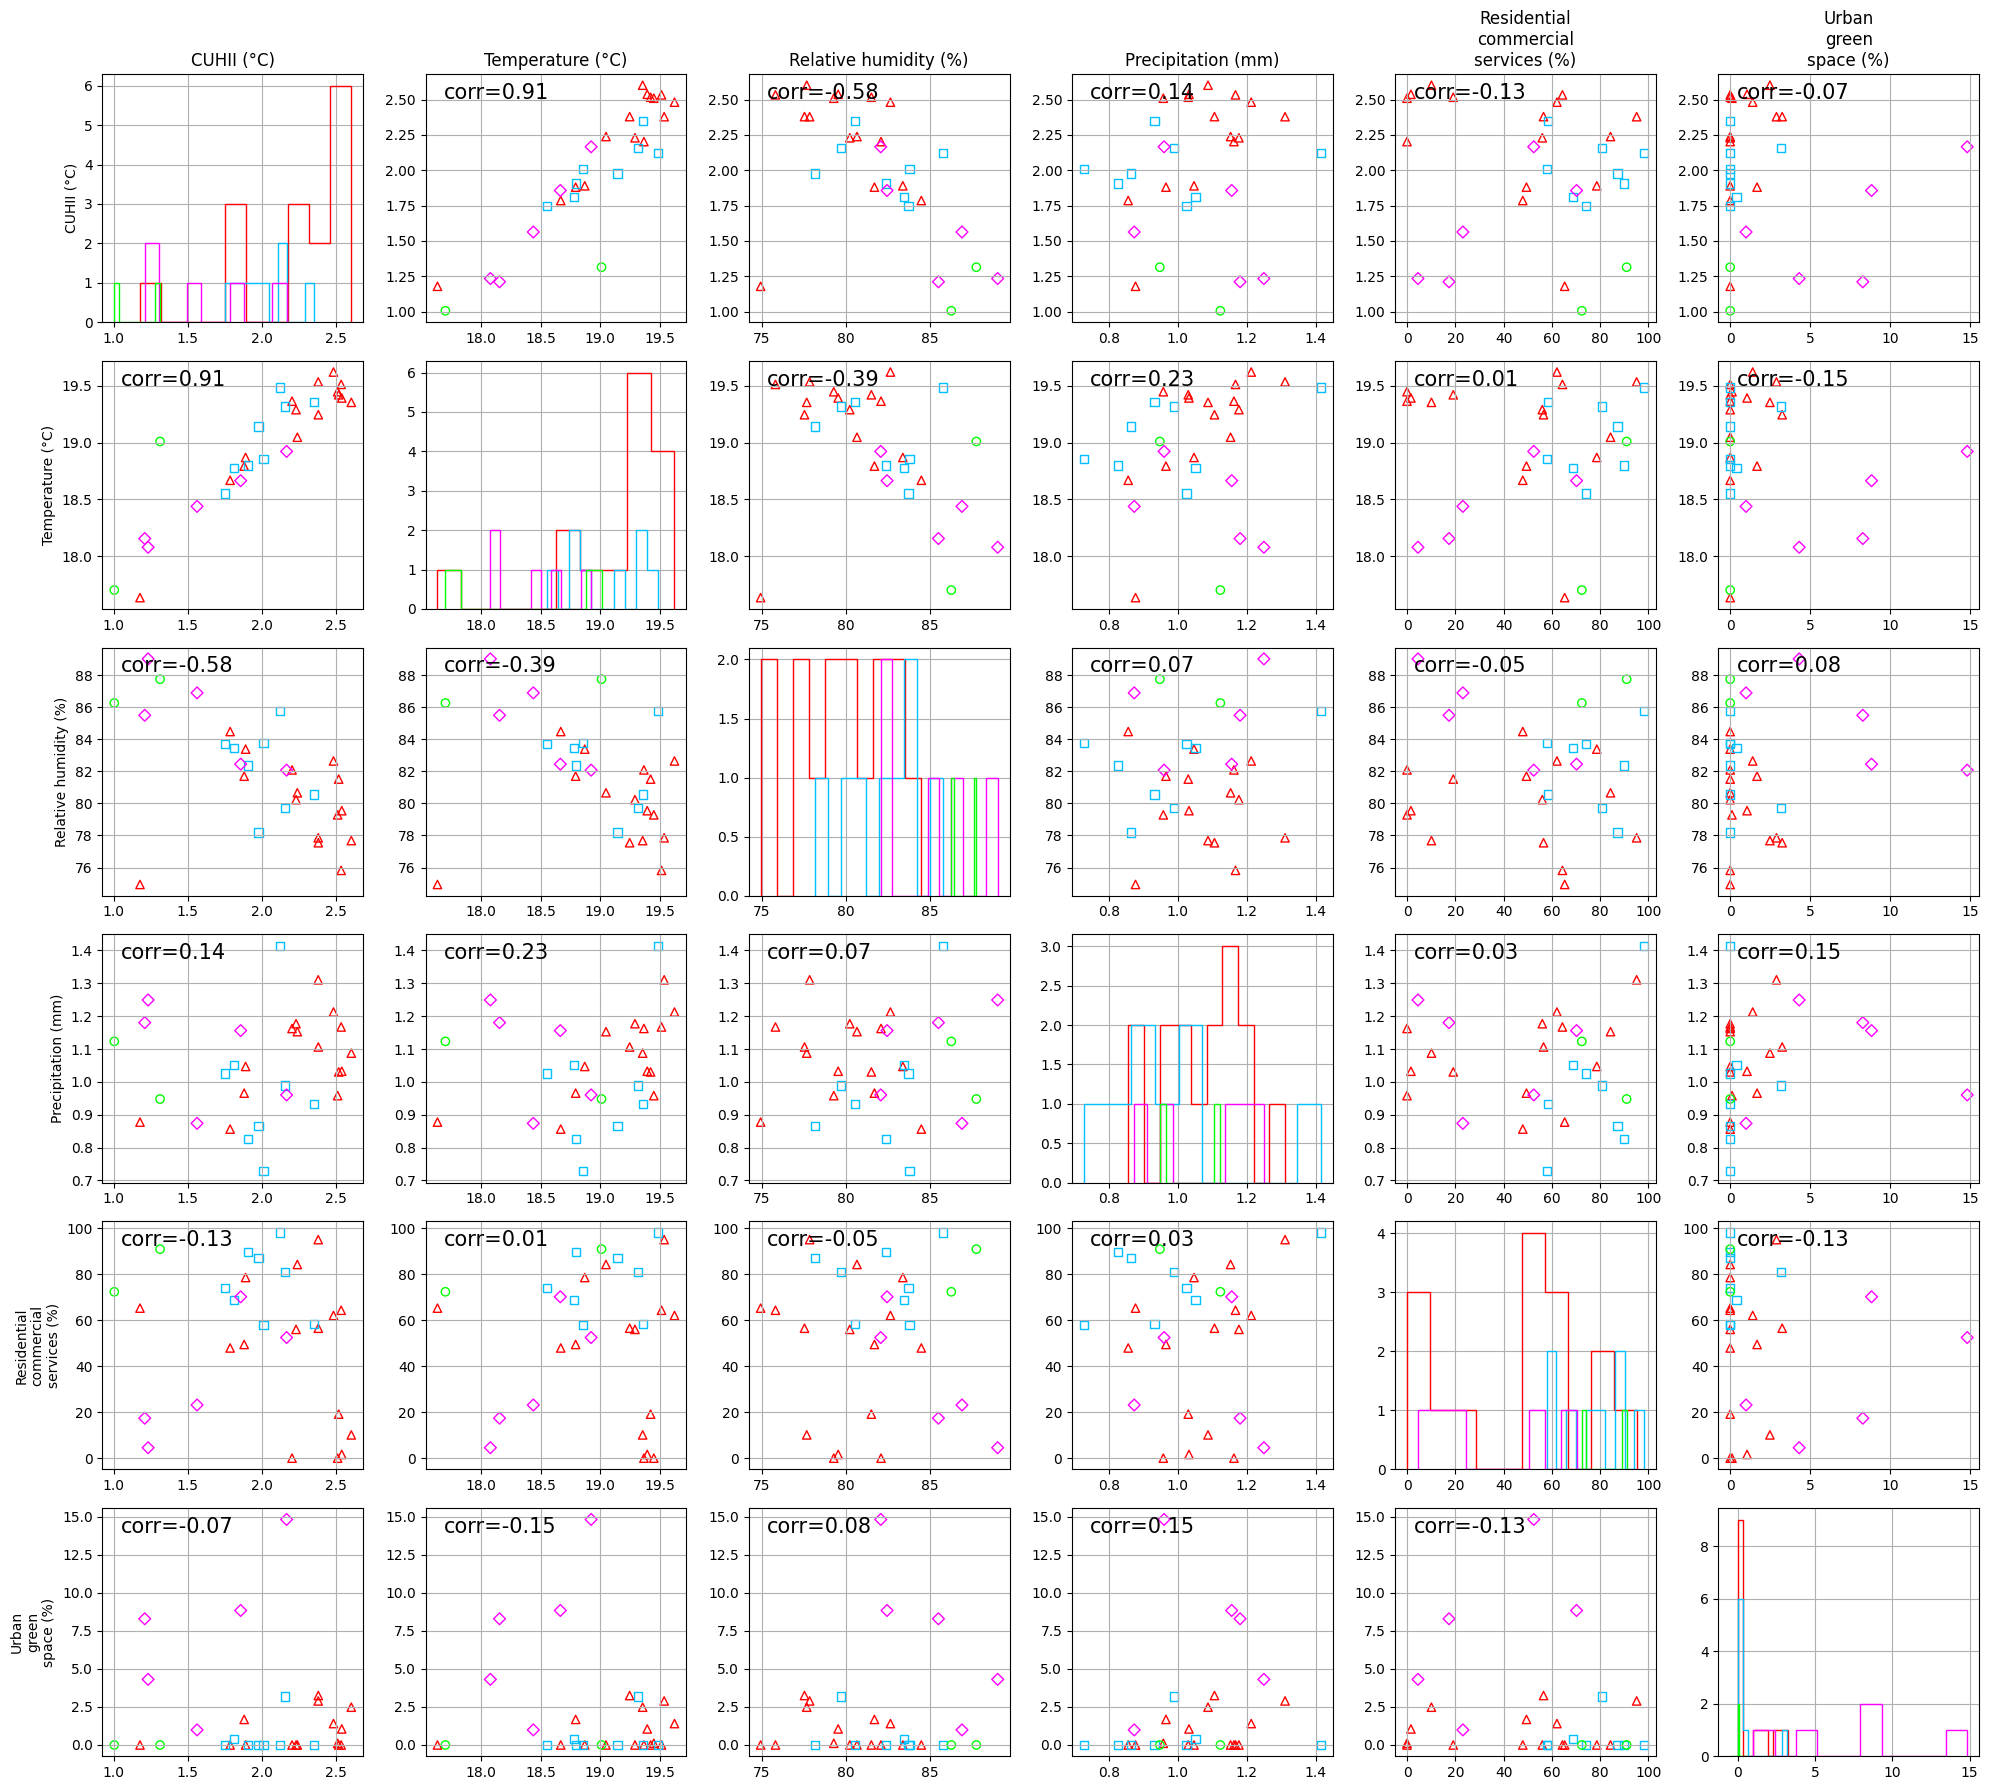

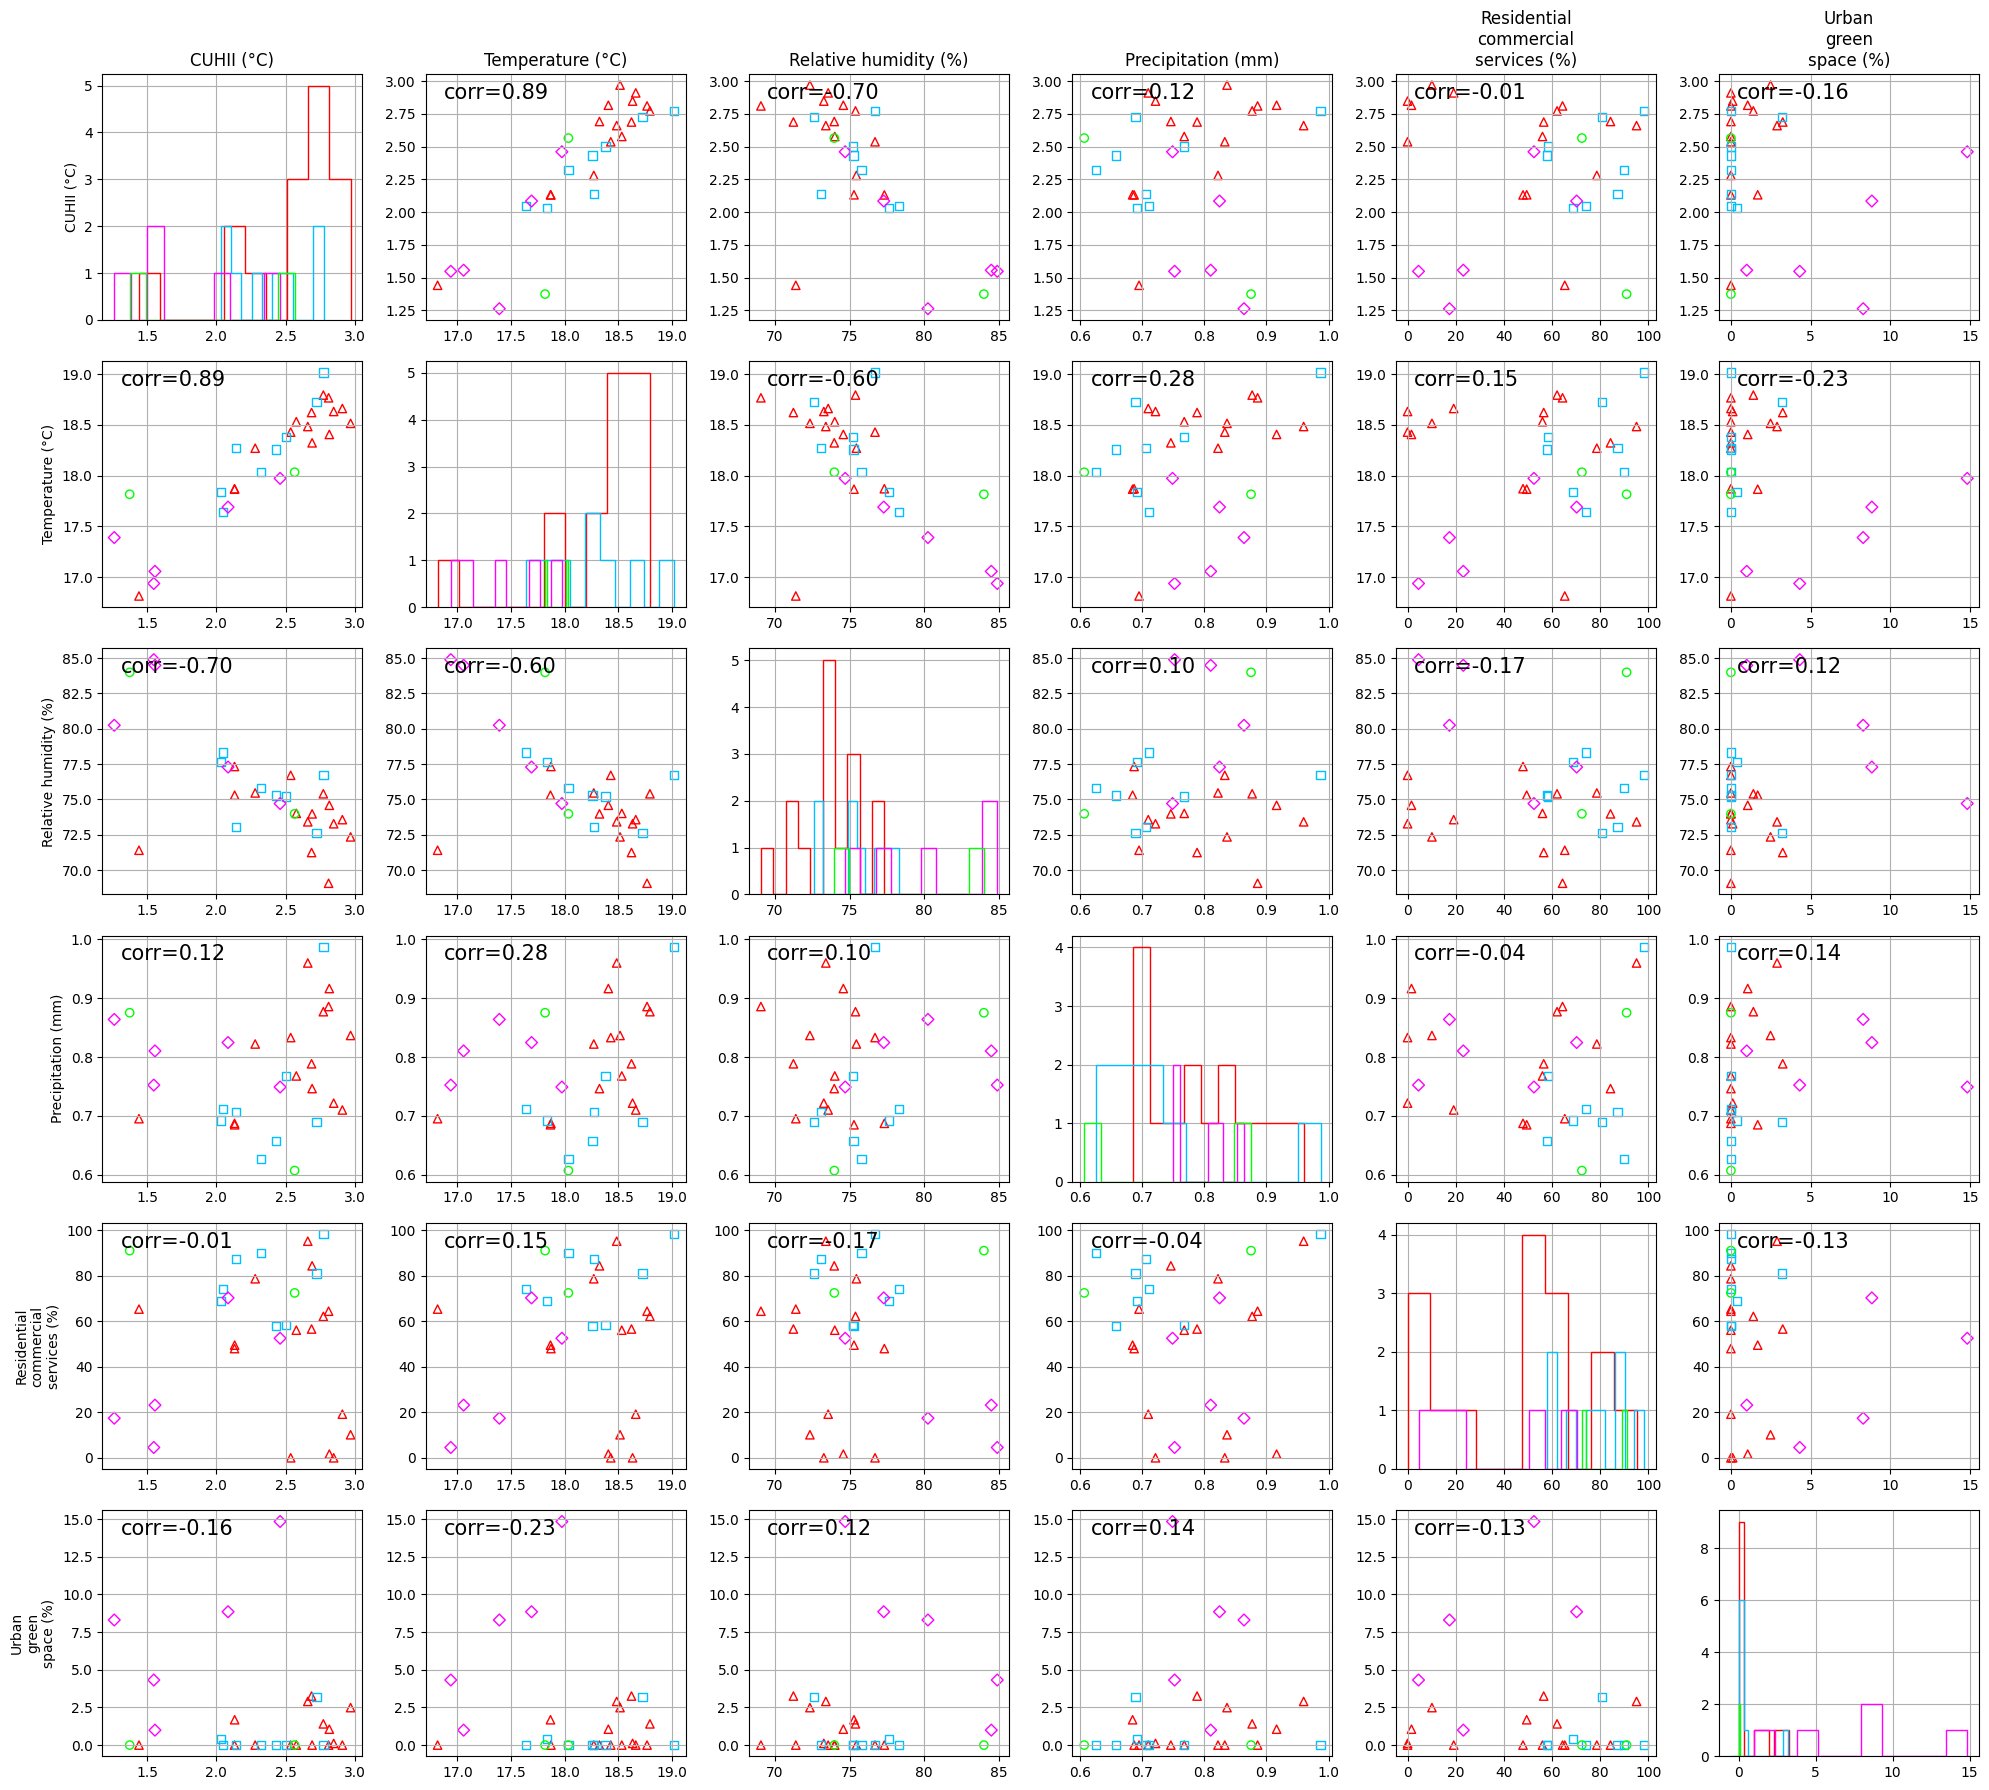

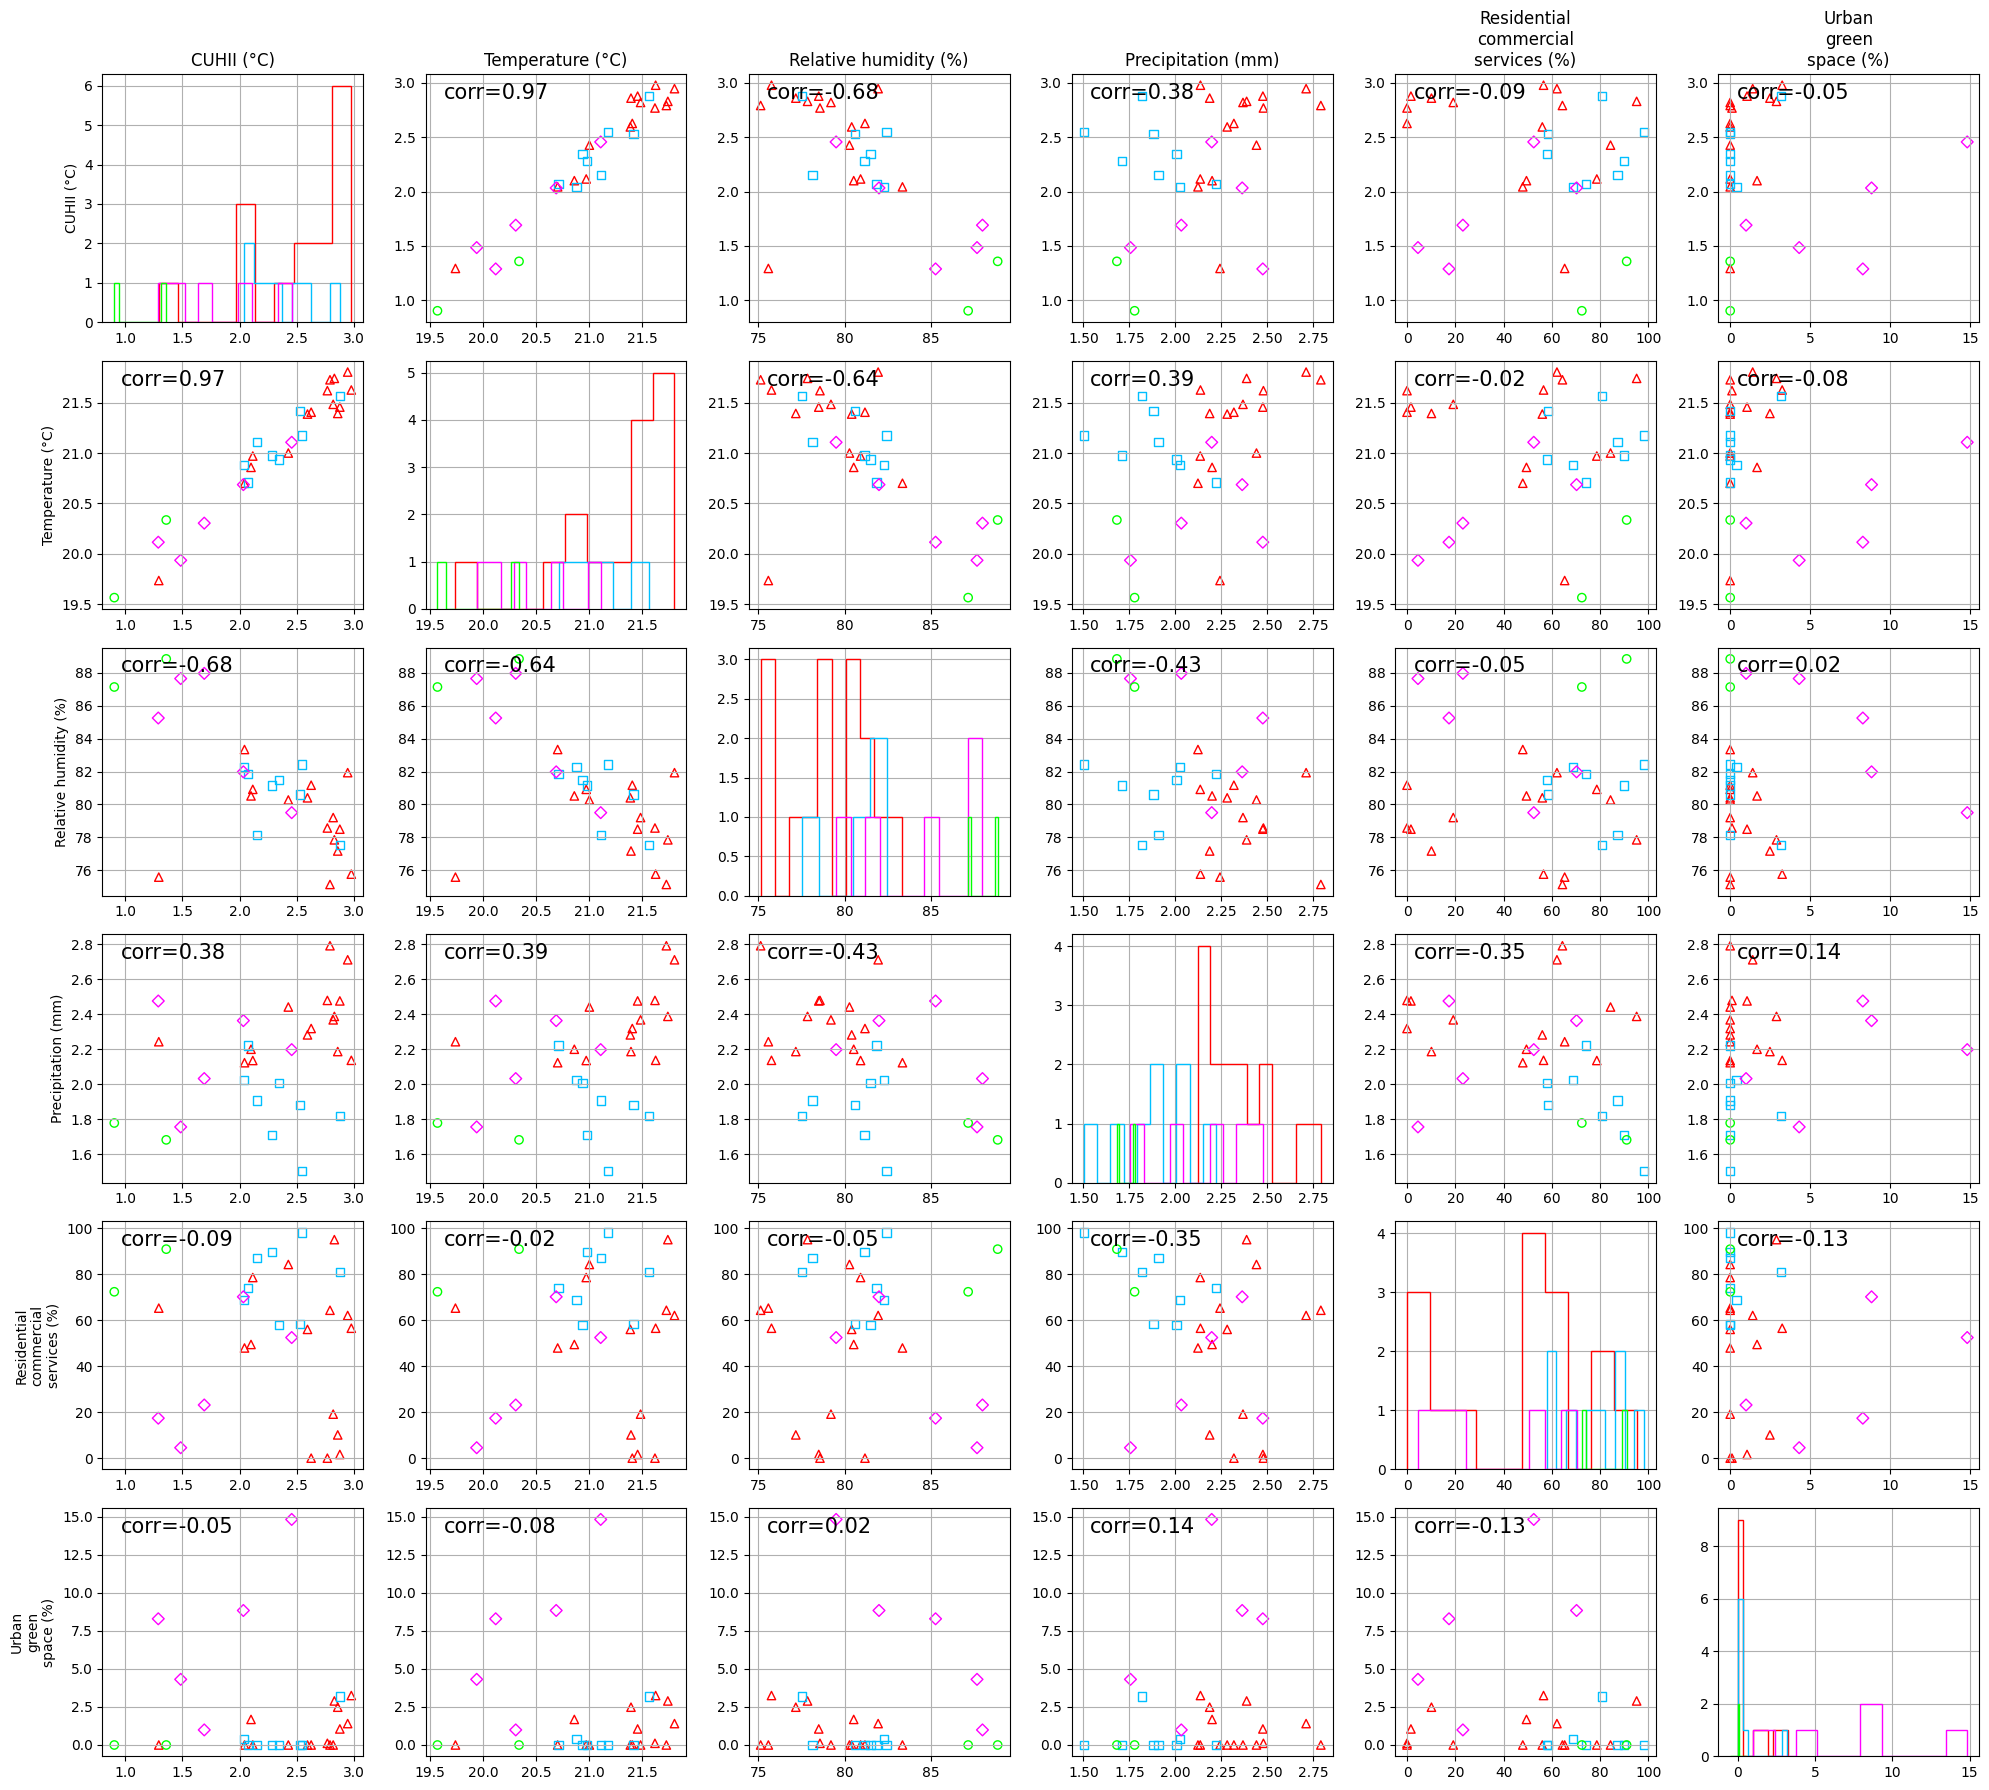

In [130]:
def pairplot(df, name):
    num_vars = df.select_dtypes(include='number').columns

    fig, ax = plt.subplots(len(num_vars), len(num_vars), figsize=(20,18))

    for i in range(len(num_vars)):
        for j in range(len(num_vars)):
            if i == j:
                ax[i, j].hist(df[df.cluster == 'A'][num_vars[i]], label='Cluster A', histtype='step', color='red')
                ax[i, j].hist(df[df.cluster == 'B'][num_vars[i]], label='Cluster B', histtype='step', color='deepskyblue')
                ax[i, j].hist(df[df.cluster == 'C'][num_vars[i]], label='Cluster C', histtype='step', color='magenta')
                ax[i, j].hist(df[df.cluster == 'D'][num_vars[i]], label='Cluster D', histtype='step', color='lime')
                ax[i, j].grid()
            else:
                ax[i, j].scatter(df[df.cluster == 'A'][num_vars[j]], df[df.cluster == 'A'][num_vars[i]], marker='^', label='Cluster A', facecolors='none', edgecolors='red')
                ax[i, j].scatter(df[df.cluster == 'B'][num_vars[j]], df[df.cluster == 'B'][num_vars[i]], marker='s', label='Cluster B', facecolors='none', edgecolors='deepskyblue')
                ax[i, j].scatter(df[df.cluster == 'C'][num_vars[j]], df[df.cluster == 'C'][num_vars[i]], marker='D', label='Cluster C', facecolors='none', edgecolors='magenta')
                ax[i, j].scatter(df[df.cluster == 'D'][num_vars[j]], df[df.cluster == 'D'][num_vars[i]], marker='o', label='Cluster D', facecolors='none', edgecolors='lime')
                
                corr = np.corrcoef(df[num_vars[j]], df[num_vars[i]])[0, 1]
                ax[i, j].text(0.07, 0.9, f'corr={corr:.2f}', transform=ax[i, j].transAxes, size=15)
                ax[i, j].grid()

            if i == 0:
                ax[i, j].set_title(num_vars[j])
            if j == 0:
                ax[i, j].set_ylabel(num_vars[i])

    
    plt.tight_layout()
    plt.savefig(f'../figures/corr_matrix_{name}.png', dpi=300, bbox_inches="tight")
    plt.show()

pairplot(summer, 'summer')
pairplot(autumn, 'autumn')
pairplot(winter, 'winter')
pairplot(spring, 'spring')

In [134]:
summer.drop(columns=['cluster']).corr()

,CUHII (°C),Temperature (°C),Relative humidity (%),Precipitation (mm),Residential\ncommercial\nservices (%),Urban\ngreen\nspace (%)
CUHII (°C),1.000000,0.926327,-0.643337,0.257081,-0.142278,-0.073201
Temperature (°C),0.926327,1.000000,-0.578449,0.168591,0.030724,-0.172256
Relative humidity (%),-0.643337,-0.578449,1.000000,-0.165973,-0.035075,0.076620
Precipitation (mm),0.257081,0.168591,-0.165973,1.000000,-0.228572,0.136734
Residential\ncommercial\nservices (%),-0.142278,0.030724,-0.035075,-0.228572,1.000000,-0.133388
Urban\ngreen\nspace (%),-0.073201,-0.172256,0.076620,0.136734,-0.133388,1.000000


In [135]:
autumn.drop(columns=['cluster']).corr()

,CUHII (°C),Temperature (°C),Relative humidity (%),Precipitation (mm),Residential\ncommercial\nservices (%),Urban\ngreen\nspace (%)
CUHII (°C),1.000000,0.909487,-0.583697,0.144310,-0.132376,-0.074431
Temperature (°C),0.909487,1.000000,-0.392179,0.225284,0.013794,-0.147559
Relative humidity (%),-0.583697,-0.392179,1.000000,0.065959,-0.046777,0.083067
Precipitation (mm),0.144310,0.225284,0.065959,1.000000,0.025152,0.153180
Residential\ncommercial\nservices (%),-0.132376,0.013794,-0.046777,0.025152,1.000000,-0.133388
Urban\ngreen\nspace (%),-0.074431,-0.147559,0.083067,0.153180,-0.133388,1.000000


In [136]:
winter.drop(columns=['cluster']).corr()

,CUHII (°C),Temperature (°C),Relative humidity (%),Precipitation (mm),Residential\ncommercial\nservices (%),Urban\ngreen\nspace (%)
CUHII (°C),1.000000,0.890332,-0.702470,0.115453,-0.014710,-0.162967
Temperature (°C),0.890332,1.000000,-0.603821,0.284604,0.149737,-0.228964
Relative humidity (%),-0.702470,-0.603821,1.000000,0.104856,-0.170516,0.119342
Precipitation (mm),0.115453,0.284604,0.104856,1.000000,-0.039822,0.135280
Residential\ncommercial\nservices (%),-0.014710,0.149737,-0.170516,-0.039822,1.000000,-0.133388
Urban\ngreen\nspace (%),-0.162967,-0.228964,0.119342,0.135280,-0.133388,1.000000


In [137]:
spring.drop(columns=['cluster']).corr()

,CUHII (°C),Temperature (°C),Relative humidity (%),Precipitation (mm),Residential\ncommercial\nservices (%),Urban\ngreen\nspace (%)
CUHII (°C),1.000000,0.971410,-0.681134,0.376806,-0.089425,-0.051509
Temperature (°C),0.971410,1.000000,-0.641886,0.391000,-0.016305,-0.082843
Relative humidity (%),-0.681134,-0.641886,1.000000,-0.433542,-0.053736,0.024008
Precipitation (mm),0.376806,0.391000,-0.433542,1.000000,-0.345187,0.135824
Residential\ncommercial\nservices (%),-0.089425,-0.016305,-0.053736,-0.345187,1.000000,-0.133388
Urban\ngreen\nspace (%),-0.051509,-0.082843,0.024008,0.135824,-0.133388,1.000000
